In [1]:
import torch
import dgl
import numpy as np
import pandas as pd
import os
import pickle
from NLPUtils.preprocessUtils import removePunctuation, removeWord
from NLPUtils.DataModel import Vocabulary
from nltk.corpus import stopwords


c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT = '.\\R8'
TRAIN = 'train.txt'
TEST = 'test.txt'

In [3]:
UNK = '<unk>'
MAXLEN = 100

In [4]:
removeWordList = stopwords.words('english')

In [5]:
df = pd.read_csv(os.path.join(ROOT, TRAIN), encoding='utf-8',sep='\t', header=None)

In [6]:
label2idx = {label : i for i, label in enumerate(df[0].unique())}

In [7]:
y_train = []
for label in df[0]:
    y_train.append(label2idx[label])
y_train = np.array(y_train)

In [8]:
SPECIAL_TOKEN = {'<unk>' : 0}

In [9]:
voc = Vocabulary(TOKENS=SPECIAL_TOKEN, MAXLEN=MAXLEN)

In [10]:
x_datas = []

In [11]:
for sentence in df[1]:
    x_data = removeWord(removeWordList=removeWordList, sentence=sentence)
    voc.addSentence(x_data)
    x_datas.append(x_data)

In [12]:
len(voc.word2idx)

17277

In [13]:
voc.num_words

17277

In [14]:
with open('./R8/voc.data', 'wb') as f:
    pickle.dump(voc, f)

In [15]:
x_list = []

for sentence in x_datas:
    idxList = [voc.word2idx[word] for word in sentence.split()[:MAXLEN]]
    while len(idxList) < MAXLEN:
        idxList.append(voc.word2idx['<unk>'])
    x_list.append(idxList)

In [16]:
x_train = np.array(x_list, dtype=np.int64)

In [17]:
len(x_train) == len(y_train)

True

# Constructing Graph (Inductive)

In [18]:
from dgl.data import DGLDataset

class R8InductiveGraphDataset(DGLDataset):

    def __init__(self, x : np.ndarray, y : np.ndarray, window_size = 3,  name = "R8"):
        super().__init__(name)
        self.datas = []
        self.y = y
        self.graphs = []
        self.labels = torch.from_numpy(self.y).type(torch.long)

        for data in x:
            src_nodes = []
            dst_nodes = []
            self.datas.append(torch.from_numpy(np.unique(data)))
            hashTable = self.constructHash(np.unique(data))
            nodeIds = [hashTable[i] for i in data]
            for i in range(len(nodeIds) - window_size + 1):
                window = nodeIds[i : i + window_size]
                src, dst = self.connectFully(window=window)
                src_nodes += src
                dst_nodes += dst
            graph = dgl.graph(data=(src_nodes, dst_nodes))
            graph = dgl.add_self_loop(graph)
            self.graphs.append(graph)

    def constructHash(self, data):
        wordId2nodeId = {wordId: nodeId for nodeId, wordId in enumerate(data)}
        return wordId2nodeId
        
    def connectFully(self, window):
        src_nodes = []
        dst_nodes = []
        for j in range(len(window)):
            for k in range(j + 1, len(window)):
                src_nodes.append(window[j])
                dst_nodes.append(window[k])
        temp_src = src_nodes
        temp_dst = dst_nodes
        src_nodes = src_nodes + temp_dst
        dst_nodes = dst_nodes + temp_src
        return src_nodes, dst_nodes

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.datas[idx], self.labels[idx]
# load Dataset
dataset = R8InductiveGraphDataset(x = x_train, y = y_train)

In [19]:
graph, data, y = dataset[100]
print(graph)
print(data.shape)

Graph(num_nodes=52, num_edges=640,
      ndata_schemes={}
      edata_schemes={})
torch.Size([52])


In [20]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
dataLoader = GraphDataLoader(dataset=dataset, batch_size = 5)

In [21]:
from dgl.nn.pytorch import GraphConv
# https://docs.dgl.ai/en/latest/generated/dgl.nn.pytorch.conv.GraphConv.html
class GCN(torch.nn.Module):
    def __init__(self, voc_len, embeding_dim , h_feats, num_classes):
        super(GCN, self).__init__()
        self.embddingLayer = torch.nn.Embedding(voc_len, embeding_dim)
        self.conv1 = GraphConv(embeding_dim, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, data):
        nodes_feat = self.embddingLayer(data)
        h = self.conv1(g, nodes_feat)
        h = torch.nn.functional.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')
        

# Create the model with given dimensions
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN(voc.num_words, 200, 16, 8).to(DEVICE)

# graph, data, y = dataset[1]
# pred = model(graph, data)

# print(pred)

In [22]:
from tqdm import tqdm

In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
opti = torch.optim.Adam(model.parameters())
losses = []
for epoch in range(20):
    for graph, data, y in tqdm(dataset):
        graph, data, y = graph.to(DEVICE), data.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred = model(graph, data)
        loss = loss_fn(pred, y.view(-1))
        loss.backward()
        opti.step()
        loss_value = loss.item()
    losses.append(loss_value)

100%|██████████| 5485/5485 [00:31<00:00, 174.77it/s]


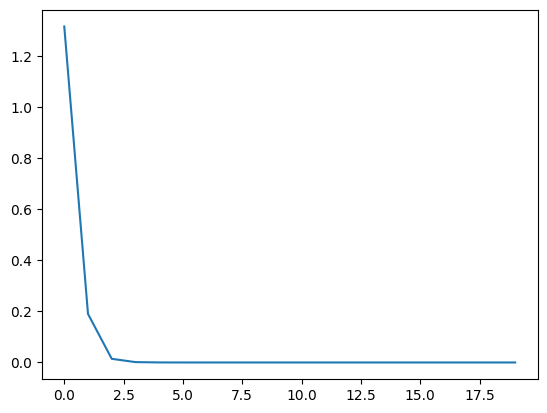

In [24]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [25]:
correct = 0.
with torch.no_grad():
    for graph, data, y in dataset:
        graph, data, y = graph.to(DEVICE), data.to(DEVICE), y.to(DEVICE)
        pred = model(graph, data)
        correct += (pred.argmax() == y).type(torch.float32).item()
print(correct / len(dataset))
    

0.9990884229717412


In [26]:
df = pd.read_csv(os.path.join(ROOT, TEST), encoding='utf-8',sep='\t', header=None)
y_test = []
for label in df[0]:
    y_test.append(label2idx[label])
y_test = np.array(y_test)

In [27]:
x_test = []
for sentence in df[1]:
    sentence = removeWord(removeWordList=removeWordList, sentence=sentence)
    sentence = sentence.split()
    x_data = []
    for word in sentence[:MAXLEN]:
        if word in voc.word2idx:
            x_data.append(voc.word2idx[word])
        else:
            x_data.append(0)
    while len(x_data) < MAXLEN:
        x_data.append(0)
    x_test.append(x_data)
x_test = np.array(x_test, dtype=np.int64)

In [28]:
x_test.shape

(2189, 100)

In [29]:
test_dataset = R8InductiveGraphDataset(x = x_test, y = y_test)

In [30]:
correct = 0.
with torch.no_grad():
    for graph, data, y in test_dataset:
        graph, data, y = graph.to(DEVICE), data.to(DEVICE), y.to(DEVICE)
        pred = model(graph, data)
        correct += (pred.argmax() == y).type(torch.float32).item()
print(correct / len(dataset))

0.3877848678213309
